In [4]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain, combinations
# from sklearn.model_selection import cross_val_score

# before submission, check your decimal places again

# Problem 1

In [69]:
################################################################################
# Part (a)

import pickle
wine = pickle.load(open('wine.pkl', 'rb'))
print(wine['data'].shape, wine['testdata'].shape)

(88, 13) (90, 13)


In [70]:
def learn(train_x, train_y, num_classes=3):
    train_x_f1 = train_x[:, 0]
    train_x_f2 = train_x[:, 1]
    return [(np.mean(train_y == k), np.mean(train_x_f1[train_y == k]), np.mean(train_x_f2[train_y == k]), np.cov(train_x_f1[train_y == k], train_x_f2[train_y == k])) for k in range(num_classes)]

In [62]:
def predict(params, test_x):
    all_log_posteriors = []
    for prior, mu1, mu2, cor in params:
        mat = np.array([[test_x[0]-mu1],[test_x[1]-mu2]])
        log_posterior = np.log(prior) - np.log(np.linalg.det(cor))/2 - (mat.T @ np.linalg.inv(cor) @ mat)/2
        all_log_posteriors.append(log_posterior)
    
    log_posteriors = np.array(all_log_posteriors)
    return np.argmax(log_posteriors, axis=0)

In [64]:
def select_params(train_data, train_label):
    optimal_feat_idx = None
    min_err_count = 10000000
    
    feat_idx = combinations(range(train_data.shape[1]), 2)
    for i in feat_idx:
        # make a deep copy
        X = np.array(train_data)

        # track number of correct predictions given the two features
        err_count = 0

        # select two features
        idx1 = slice(i[0], i[0]+1)
        idx2 = slice(i[1], i[1]+1)
        extracted = np.hstack((X[:, idx1], X[:, idx2]))

        # leave-one-out cross validation
        for j in range(extracted.shape[0]):
            val_test = extracted[j]
            val_test_label = train_label[j]
            mask = np.ones(extracted.shape[0], bool)
            mask[0] = 0
            val_train = extracted[mask]
            val_train_label = train_label[mask]
            
            model = learn(val_train, val_train_label)
            result = predict(model, val_test)[0]
            if(result != val_test_label):
                err_count += 1

        # print(i, err_count)
            
        # check optimality
        if (min_err_count > err_count):
            min_err_count = err_count
            optimal_feat_idx = i
    return optimal_feat_idx

In [65]:
train_data = np.array(wine['data'].astype(float))
train_label = np.array(wine['labels'])

select_params(train_data, train_label)

(0, 6)

In [71]:
################################################################################
# Part (b)

train_data = np.array(wine['data'].astype(float))
train_label = np.array(wine['labels'])
test_data = np.array(wine['testdata'].astype(float))
test_label = np.array(wine['testlabels'])

extracted_train_data = np.column_stack((train_data[:, 0], train_data[:, 6]))
extracted_test_data = np.column_stack((test_data[:, 0], test_data[:, 6]))
model = learn(extracted_train_data, train_label)

print(model)

train_err = 0
test_err = 0

# find training error rates
for i in range(extracted_train_data.shape[0]):
    pred = predict(model, extracted_train_data[i])[0]
    if (pred != train_label[i]):
        train_err += 1

train_error_rate = train_err/train_data.shape[0]
print(train_error_rate)

# find test error rates
for i in range(extracted_test_data.shape[0]):
    pred = predict(model, extracted_test_data[i])[0]
    if (pred != test_label[i]):
        test_err += 1

test_error_rate = test_err/test_data.shape[0]
print(test_error_rate)

[(0.32954545454545453, 13.771379310344829, 3.0075862068965518, array([[0.23628374, 0.06198559],
       [0.06198559, 0.12301182]])), (0.3977272727272727, 12.220857142857144, 1.9999999999999996, array([[0.21636101, 0.05461471],
       [0.05461471, 0.44718235]])), (0.2727272727272727, 13.126666666666665, 0.7758333333333333, array([[0.24196232, 0.05349855],
       [0.05349855, 0.09212101]]))]
0.045454545454545456
0.07777777777777778


# Problem 2

In [72]:
# Pr(Y=1|X=x) = p0 if x <= t1
# Pr(Y=1|X=x) = p1 if t1 < x < t2
# Pr(Y=1|X=x) = p2 if x >= t2

t1 = 0.2
t2 = 0.8
p0 = 0.25
p1 = 0.6
p2 = 0.3

In [79]:
################################################################################
# Part (b)

# Function to implement
def stump_err(t, a, b):
    if (t<0 or t>1):
        return 0.47
    # elif(a==1 and b==1):
    #     return 0.53
    if(a==1 and b==0):
        if(t<=t1):
            return 0.75*t + 0.25*(0.2-t) + 0.42
        elif(t<t2):
            return 0.4*(t-0.2) + 0.6*(0.8-t) + 0.21
        else:
            return 0.7*(t-0.8) + 0.3*(1-t) + 0.39
    else:
        if(t<=t1):
            return 0.25*t + 0.75*(0.2-t) + 0.38
        elif(t<t2):
            return 0.6*(t-0.2) + 0.4*(0.8-t) + 0.19
        else:
            return 0.3*(t-0.8) + 0.7*(1-t) + 0.41
        

print(f'T1: {stump_err(0.4,0,1)}')
print(f'T2: {stump_err(0.5,0,1)}')
print(f'T3: {stump_err(0.5,1,0)}')

T1: 0.47000000000000003
T2: 0.49000000000000005
T3: 0.51


In [83]:
################################################################################
# Part (c)
def min_err(t):
    return min(stump_err(t,0,1), stump_err(t,1,0), stump_err(t,0,0), stump_err(t,1,1))

# Plotting code
t_vals = np.linspace(-0.2, 1.2, num=14001)
best_stump_err_rates = np.array([min_err(t) for t in t_vals])

plt.figure()
plt.plot(t_vals, best_stump_err_rates)
plt.xlabel('$t$')
plt.ylabel('best stump error rate with predicate $x \leq t$')
plt.savefig('error_rates.pdf', bbox_inches='tight')
plt.close()

# find smallest value
print(min_err(0.2))
print(min_err(0.8))
print(min_err(1))

0.43
0.45
0.47


In [84]:
################################################################################
# Part (d)

def calc_err_rate(t, a, b, x, y):
    err = 0
    if(a==1 and b==0):
        for i in range(len(y)):
            if (x[i] <= t and y[i] == 0):
                err += 1
            if (x[i] > t and y[i] == 1):
                err += 1
    else:
        for i in range(len(y)):
            if (x[i] <= t and y[i] == 1):
                err += 1
            if (x[i] > t and y[i] == 0):
                err += 1
    return err/len(y)

# Function to implement
def find_best_stump(x,y):
    t = 0
    a = 0
    b = 0
    train_err_rate = 1
    for t_val in x:
        err01 = calc_err_rate(t_val, 0, 1, x, y)
        err10 = calc_err_rate(t_val, 1, 0, x, y)
        err_rate = min(err01, err10)
        
        if(err_rate < train_err_rate):
            t = t_val
            train_err_rate = err_rate
            if (err_rate == err01):
                a=0
                b=1
            else:
                a=1
                b=0
    
    return (t, a, b, train_err_rate)

x = np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9 ])
y = np.array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1])
t, a, b, train_err = find_best_stump(x, y)
print(f'{(t,a,b)}, {train_err:.3}')

(0.75, 0, 1), 0.176


In [81]:
################################################################################
# Part (e)

# Function to generate data
def generate_data(n):
    x = np.random.rand(n)
    z = np.random.rand(n)
    y = np.zeros(n)
    y[x <= t1] = z[x <= t1] <= p0
    y[(x > t1) * (x < t2)] = z[(x > t1) * (x < t2)] <= p1
    y[x >= t2] = z[x >= t2] <= p2
    return (x,y)

print(generate_data(100))

# Simulation code
np.random.seed(42)
n = 100
num_trials = 5000
error_rates = np.zeros(num_trials)
thresholds = np.zeros(num_trials)
for trial in range(num_trials):
    t, a, b, _ = find_best_stump(*generate_data(n))
    thresholds[trial] = t
    error_rates[trial] = stump_err(t, a, b)

# Plotting code
plt.figure()
plt.hist(thresholds, bins=50)
plt.xlabel('$\hat\\theta$')
plt.ylabel('counts')
plt.savefig('histogram1.pdf', bbox_inches='tight')
plt.close()

plt.figure()
plt.hist(error_rates, bins=50)
plt.xlabel('error rate')
plt.ylabel('counts')
plt.savefig('histogram2.pdf', bbox_inches='tight')
plt.close()

(array([0.59515562, 0.36471714, 0.00537562, 0.56108773, 0.89657041,
       0.5317169 , 0.78048768, 0.16195431, 0.13729767, 0.89394354,
       0.78299819, 0.34741033, 0.80017235, 0.07532555, 0.51790047,
       0.88145624, 0.8436007 , 0.3712535 , 0.2288488 , 0.8678649 ,
       0.26690079, 0.82202461, 0.2665175 , 0.98453327, 0.36012019,
       0.25536162, 0.59922773, 0.35971002, 0.81042748, 0.73274968,
       0.63249549, 0.42201346, 0.83461111, 0.30613723, 0.29572187,
       0.09147569, 0.56350017, 0.69694467, 0.71299797, 0.8614045 ,
       0.56716047, 0.02552146, 0.17539044, 0.56133047, 0.31747745,
       0.86421593, 0.22854686, 0.25526907, 0.84298551, 0.58131603,
       0.31307025, 0.92162172, 0.33191817, 0.12686282, 0.78942939,
       0.46457328, 0.4785332 , 0.05625745, 0.96862901, 0.27218752,
       0.29694098, 0.26627532, 0.75628962, 0.93196089, 0.38916526,
       0.37645551, 0.42328152, 0.68977377, 0.89497177, 0.6645538 ,
       0.91370472, 0.57982936, 0.21888132, 0.80832659, 0.2029

# Problem 3

In [145]:
prostate = pickle.load(open('prostate.pkl', 'rb'))
prostate

{'names': ['lcavol',
  'lweight',
  'age',
  'lbph',
  'svi',
  'lcp',
  'gleason',
  'pgg45',
  'lpsa'],
 'data': array([[-5.79818495e-01,  2.76945900e+00,  5.00000000e+01,
         -1.38629436e+00,  0.00000000e+00, -1.38629436e+00,
          6.00000000e+00,  0.00000000e+00, -4.30782900e-01],
        [-9.94252273e-01,  3.31962600e+00,  5.80000000e+01,
         -1.38629436e+00,  0.00000000e+00, -1.38629436e+00,
          6.00000000e+00,  0.00000000e+00, -1.62518900e-01],
        [-5.10825624e-01,  2.69124300e+00,  7.40000000e+01,
         -1.38629436e+00,  0.00000000e+00, -1.38629436e+00,
          7.00000000e+00,  2.00000000e+01, -1.62518900e-01],
        [-1.20397280e+00,  3.28278900e+00,  5.80000000e+01,
         -1.38629436e+00,  0.00000000e+00, -1.38629436e+00,
          6.00000000e+00,  0.00000000e+00, -1.62518900e-01],
        [ 7.51416089e-01,  3.43237300e+00,  6.20000000e+01,
         -1.38629436e+00,  0.00000000e+00, -1.38629436e+00,
          6.00000000e+00,  0.00000000e+00,

In [153]:
lpsa = prostate['data'][:,-1]
lpsa
# print(np.dot(lpsa, lpsa))

array([-0.4307829, -0.1625189, -0.1625189, -0.1625189,  0.3715636,
        0.7654678,  0.8544153,  1.2669476,  1.2669476,  1.2669476,
        1.3480731,  1.446919 ,  1.4701758,  1.4929041,  1.5581446,
        1.5993876,  1.6389967,  1.6956156,  1.7137979,  1.8000583,
        1.8484548,  1.8946169,  1.9242487,  2.008214 ,  2.0476928,
        2.1575593,  2.1916535,  2.2137539,  2.2772673,  2.2975726,
        2.3272777,  2.5217206,  2.5533438,  2.5687881,  2.6567569,
        2.677591 ,  2.7180005,  2.7942279,  2.8063861,  2.8124102,
        2.8419982,  2.8535925,  2.9204698,  2.9626924,  2.9626924,
        2.9729753,  3.0130809,  3.0373539,  3.2752562,  3.3375474,
        3.3928291,  3.4355988,  3.4578927,  3.5160131,  3.5307626,
        3.5652984,  3.5876769,  3.6309855,  3.6800909,  3.7123518,
        3.9843437,  3.993603 ,  4.029806 ,  4.1295508,  4.3851468,
        4.6844434,  5.477509 ])

In [195]:
################################################################################
# Part (a

data = np.array(prostate['data'])
s = data.shape[0]
result = []

for i in range(data.shape[1]-1):
    idx = slice(i, i+1)
    avg_x = np.average(data[:,idx])
    avg_x_squared = np.average(np.square(data[:,idx]))
    reshaped = data[:,idx].reshape(67,)
    avg_xy = np.dot(reshaped, lpsa)/s
    avg_y = np.average(lpsa)
    m = (avg_xy - avg_x * avg_y)/(avg_x_squared - avg_x**2)
    b = avg_y - m * avg_x
    result.append((i, m, b))

print(result)

[(0, 0.7126351414619184, 1.5163048466380729), (1, 1.2296428587841983, -2.0064723368951762), (2, 0.036649101743785197, 0.07945249754417594), (3, 0.2169768426116095, 2.4368442793549843), (4, 1.6015040342307691, 2.0937994057692304), (5, 0.4218252474401755, 2.54270132258143), (6, 0.583452763006299, -1.4750757524752367), (7, 0.01846843347341114, 1.967204146071588)]


In [227]:
################################################################################
# Part (a) : three significant digits

data = np.array(prostate['data'])
s = data.shape[0]
result = []

for i in range(data.shape[1]-1):
    idx = slice(i, i+1)
    avg_x = np.average(data[:,idx])
    avg_x_squared = np.average(np.square(data[:,idx]))
    reshaped = data[:,idx].reshape(67,)
    avg_xy = np.dot(reshaped, lpsa)/s
    avg_y = np.average(lpsa)
    m = (avg_xy - avg_x * avg_y)/(avg_x_squared - avg_x**2)
    b = avg_y - m * avg_x
    result.append((f'{m:.3}', f'{b:.3}'))

print(result)

[('0.713', '1.52'), ('1.23', '-2.01'), ('0.0366', '0.0795'), ('0.217', '2.44'), ('1.6', '2.09'), ('0.422', '2.54'), ('0.583', '-1.48'), ('0.0185', '1.97')]


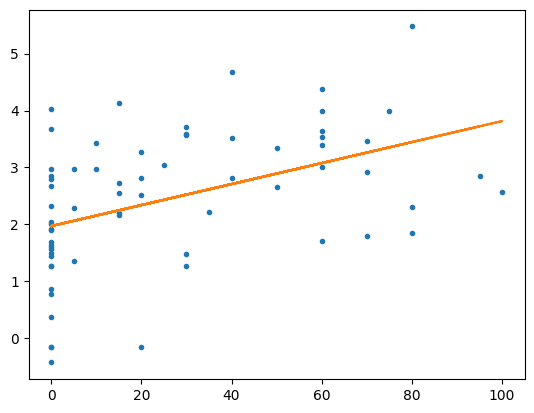

1.9672041460715881 0.01846843347341111


In [196]:
# testing out
x = np.array(prostate['data'][:,7])
y = np.array(prostate['data'][:,-1])

# Fit with polyfit
b, m = np.polynomial.polynomial.polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

# get values
print(b,m)

In [219]:
################################################################################
# Part (b)

data = np.array(prostate['data'])
A = data[:, [0,1,2,3,4,5,6,7]]
Astar = np.hstack((A,np.ones([A.shape[0],1], A.dtype)))
b = data[:, 8]
print(A.shape, Astar.shape, b.shape)
x = np.linalg.lstsq(Astar, b, rcond=None)
print(x)

(67, 8) (67, 9) (67,)
(array([ 0.57654319,  0.61402   , -0.01900102,  0.14484808,  0.73720864,
       -0.20632423, -0.02950288,  0.00946516,  0.42917013]), array([29.42638446]), 9, array([5.88782237e+02, 2.12143090e+02, 1.20062607e+01, 1.10481256e+01,
       6.33434386e+00, 5.36332422e+00, 3.57572160e+00, 2.33364446e+00,
       4.54953907e-01]))


In [228]:
################################################################################
# Part (b) with formatting

data = np.array(prostate['data'])
A = data[:, [0,1,2,3,4,5,6,7]]
Astar = np.hstack((A,np.ones([A.shape[0],1], A.dtype)))
b = data[:, 8]
x = np.linalg.lstsq(Astar, b, rcond=None)
for num in x[0]:
    print(f'{num:.3}')

0.577
0.614
-0.019
0.145
0.737
-0.206
-0.0295
0.00947
0.429


In [213]:
# testing out
from sklearn.linear_model import LinearRegression

data = np.array(prostate['data'])
A = data[:, [0,1,2,3,4,5,6,7]]
b = data[:, 8]
reg = LinearRegression().fit(A, b)
print(reg.coef_, reg.intercept_)

[ 0.57654319  0.61402    -0.01900102  0.14484808  0.73720864 -0.20632423
 -0.02950288  0.00946516] 0.4291701328491042
